# Model Training on Sentiment Analysis on Toxic Twitter Language Behaviour using NLP 

### 1. Import Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# NLP preprocessing
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine learning preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### 2. Load Dataset

In [96]:
# Full path to the file on Desktop
df = pd.read_csv("/Users/pankti/Desktop/twitter_training_cleaned.csv")

In [98]:
# Verify
print(df.shape)
df.head()

(74681, 4)


,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [100]:
# Display the first 5 rows to get a quick look
print("First 5 rows:")
print(df.head())

First 5 rows:
     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               tweet  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  


### 3. Basic Dataset Information

In [103]:
# Display basic information about the DataFrame
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74681 non-null  int64 
 1   entity     74681 non-null  object
 2   sentiment  74681 non-null  object
 3   tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


In [105]:
print(f"Dataset Shape: {df.shape}") # (Number of rows, Number of columns)
print(f"\nColumn Names: {df.columns.tolist()}")

Dataset Shape: (74681, 4)

Column Names: ['id', 'entity', 'sentiment', 'tweet']


In [107]:
# For numerical columns (like 'id')
print("Numerical Description:")
print(df.describe())

Numerical Description:
                 id
count  74681.000000
mean    6432.640149
std     3740.423819
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000


In [109]:
# For categorical/object columns (like 'entity', 'sentiment', 'tweet')
print("\nCategorical Description:")
print(df.describe(include='O'))


Categorical Description:
                      entity sentiment  tweet
count                  74681     74681  73995
unique                    32         4  69490
top     TomClancysRainbowSix  Negative       
freq                    2400     22542    172


### 4. Missing Values & Duplicates

In [112]:
print("Missing Values per Column:")
print(df.isnull().sum())

Missing Values per Column:
id             0
entity         0
sentiment      0
tweet        686
dtype: int64


In [114]:
# df.drop_duplicates(subset=['tweet'], inplace=True) # Uncomment to remove duplicates

print(f"Number of duplicate tweets: {df.duplicated(subset=['tweet']).sum()}")

Number of duplicate tweets: 5190


### 5. Sentiment Distribution

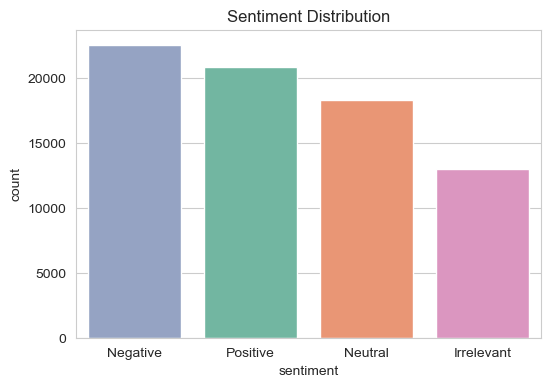

In [117]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='sentiment',
    order=df['sentiment'].value_counts().index,
    hue='sentiment',          # set sentiment as hue
    palette="Set2",
    legend=False              # remove duplicate legend
)
plt.title("Sentiment Distribution")
plt.show()

sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


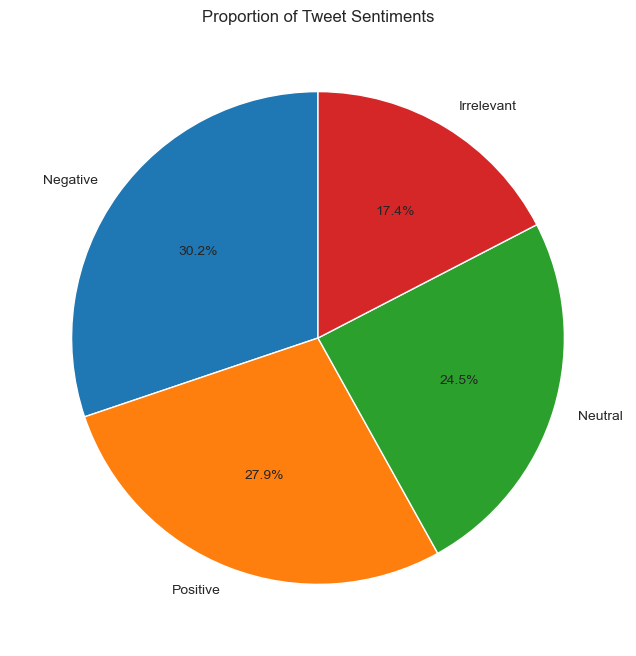

In [118]:
# Count the number of tweets per sentiment category
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Create a pie chart to show proportions
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Tweet Sentiments')
plt.show()

### 6. Text Cleaning & Preprocessing

In [122]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tweet(text):
    text = str(text).lower()                               # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)    # remove urls
    text = re.sub(r'@\w+|#\w+', '', text)                  # remove mentions & hashtags
    text = re.sub(r'[^a-z\s]', '', text)                   # remove numbers & punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_tweet'] = df['tweet'].apply(clean_tweet)

print("\nSample cleaned tweets:")
display(df[['tweet','clean_tweet']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pankti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pankti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/pankti/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Sample cleaned tweets:


,tweet,clean_tweet
0,I am coming to the borders and I will kill you...,coming border kill
1,im getting on borderlands and i will kill you ...,im getting borderland kill
2,im coming on borderlands and i will murder you...,im coming borderland murder
3,im getting on borderlands 2 and i will murder ...,im getting borderland murder
4,im getting into borderlands and i can murder y...,im getting borderland murder


### 7. Feature Engineering

In [137]:
# Ensure tweets are strings
df['tweet'] = df['tweet'].astype(str)

df['char_count'] = df['tweet'].apply(lambda x: len(str(x)))
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
df['avg_word_len'] = df['tweet'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)

print("\nFeature Engineered Sample:")
display(df[['tweet','char_count','word_count','avg_word_len']].head())


Feature Engineered Sample:


,tweet,char_count,word_count,avg_word_len
0,I am coming to the borders and I will kill you...,51,12,3.333333
1,im getting on borderlands and i will kill you ...,50,10,4.100000
2,im coming on borderlands and i will murder you...,51,10,4.200000
3,im getting on borderlands 2 and i will murder ...,57,12,3.833333
4,im getting into borderlands and i can murder y...,53,10,4.400000


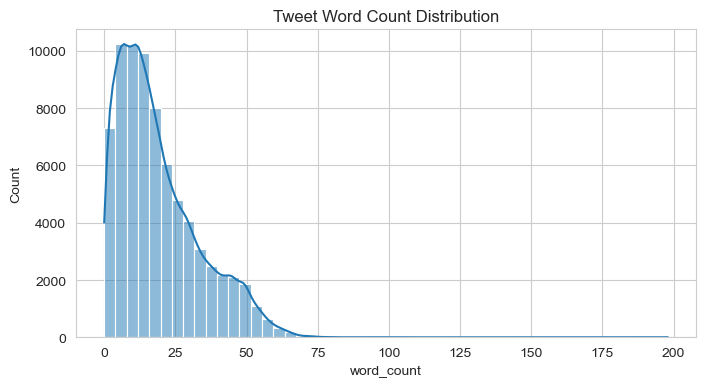

In [139]:
# Distribution of tweet word counts
plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Tweet Word Count Distribution")
plt.show()

### 8. Word Clouds for Each Sentiment

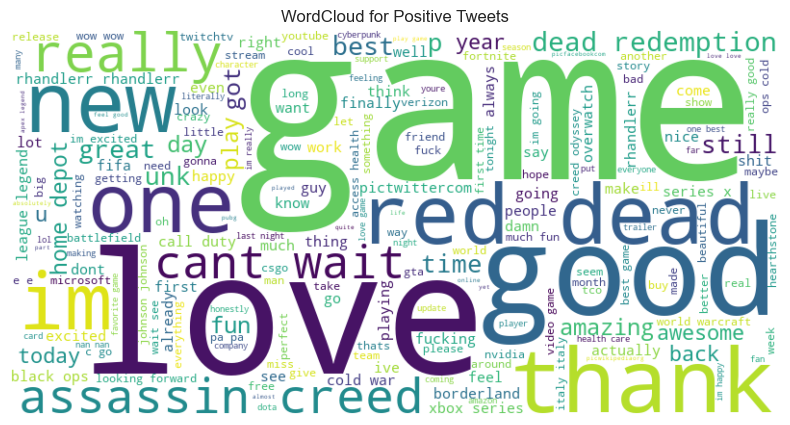

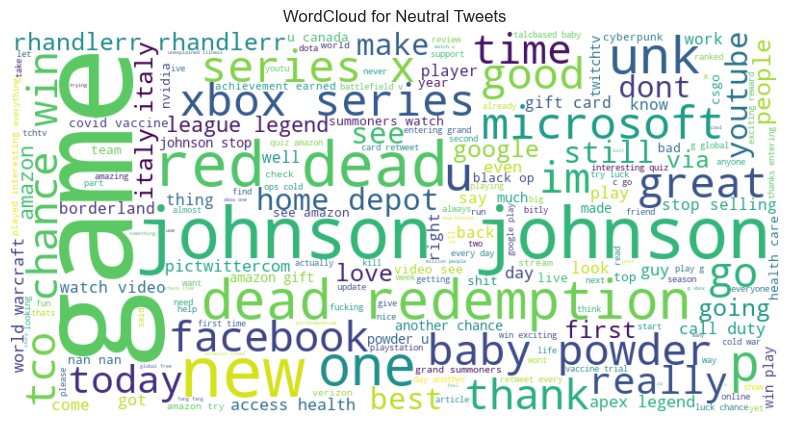

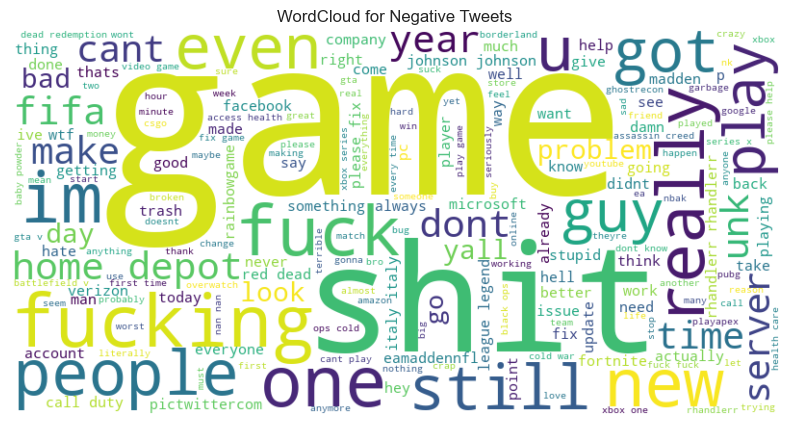

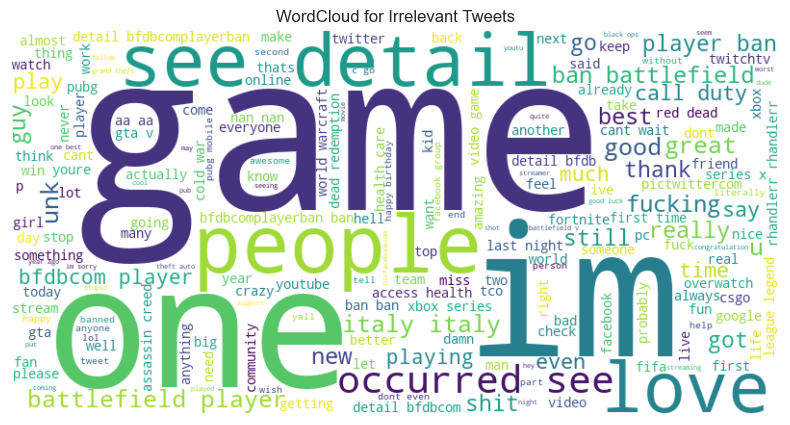

In [132]:
for sentiment in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == sentiment]['clean_tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Tweets")
    plt.show()

### 9. N-grams (Bigrams & Trigrams)

/var/folders/23/_6y5c_wj1lx7n7m6twzg3bsr0000gn/T/ipykernel_2879/327233732.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for word, count in words_freq], y=[word for word, count in words_freq], palette="viridis")


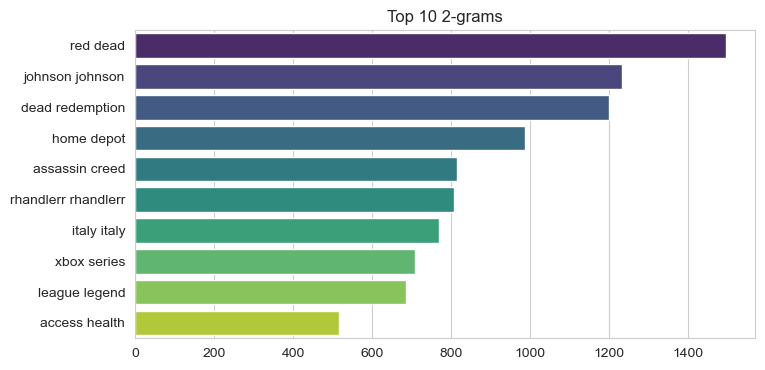

/var/folders/23/_6y5c_wj1lx7n7m6twzg3bsr0000gn/T/ipykernel_2879/327233732.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for word, count in words_freq], y=[word for word, count in words_freq], palette="viridis")


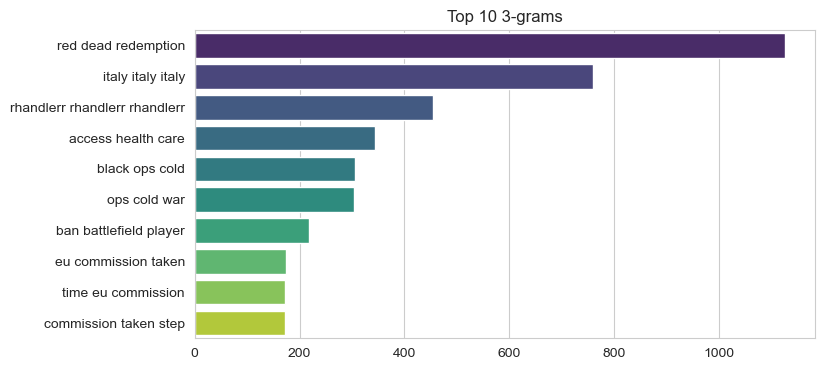

In [41]:
def plot_top_ngrams(corpus, ngram_range=(2,2), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=[count for word, count in words_freq], y=[word for word, count in words_freq], palette="viridis")
    plt.title(f"Top {n} {ngram_range[0]}-grams")
    plt.show()

# Example usage
plot_top_ngrams(df['clean_tweet'], ngram_range=(2,2), n=10)  # bigrams
plot_top_ngrams(df['clean_tweet'], ngram_range=(3,3), n=10)  # trigrams

### 10. Encode Target Labels for ML

In [43]:
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

print("\nEncoded Sentiment Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print("\nSample Encoded Sentiments:")
display(df[['sentiment','sentiment_encoded']].head())


Encoded Sentiment Mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

Sample Encoded Sentiments:


,sentiment,sentiment_encoded
0,Positive,3
1,Positive,3
2,Positive,3
3,Positive,3
4,Positive,3


In [44]:
unique_entities = df['entity'].unique()
print(unique_entities)

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']


## To Complete Model Training on Sentiment Analysis on Toxic Twitter Language Behaviour Using NLP

#### 1. Handle Missing Values and Duplicates

In [47]:
# Handle missing values in 'tweet'
df.dropna(subset=['tweet'], inplace=True)

# Remove duplicates based on 'tweet'
df.drop_duplicates(subset=['tweet'], inplace=True)

print(f"Updated shape after cleaning: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicates removed: {df.duplicated(subset=['tweet']).sum()}")

Updated shape after cleaning: (69491, 9)
Missing values: 0
Duplicates removed: 0


#### 2. Full Text Preprocessing

In [49]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Ensure NLTK data is downloaded (run once)
# nltk.download(['stopwords', 'wordnet', 'omw-1.4'])

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text), flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    # Lowercase and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text.strip()

# Apply cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Display sample
print("Sample cleaned tweets:")
print(df[['tweet', 'clean_tweet']].head())

Sample cleaned tweets:
                                               tweet  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                      clean_tweet  
0              coming border kill  
1      im getting borderland kill  
2     im coming borderland murder  
3  im getting borderland 2 murder  
4    im getting borderland murder  


#### 3.Advanced EDA - Word Clouds

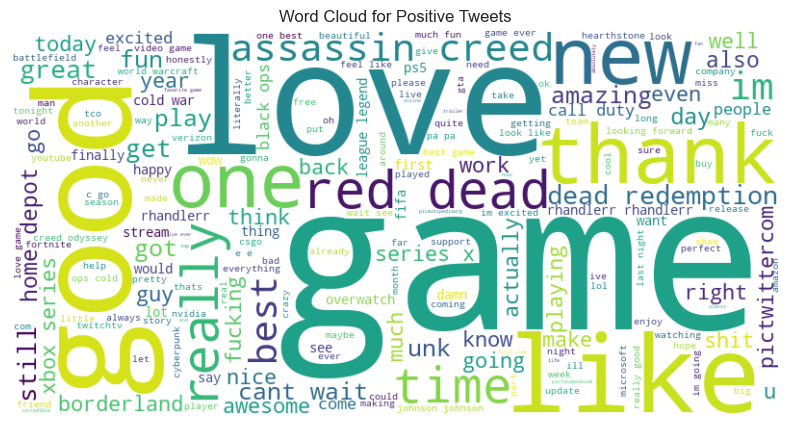

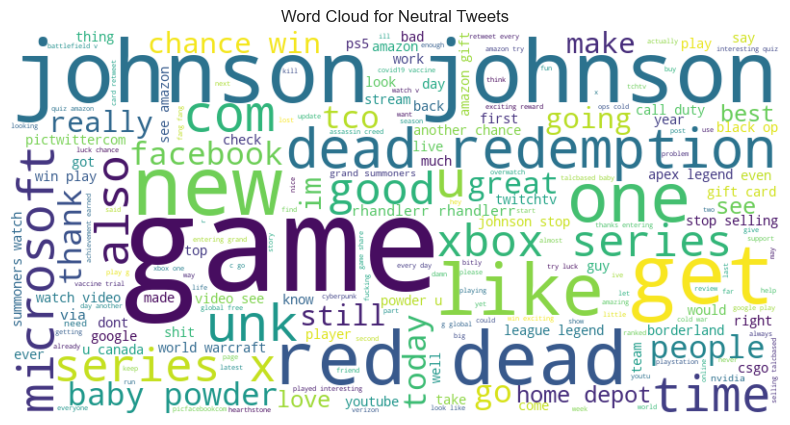

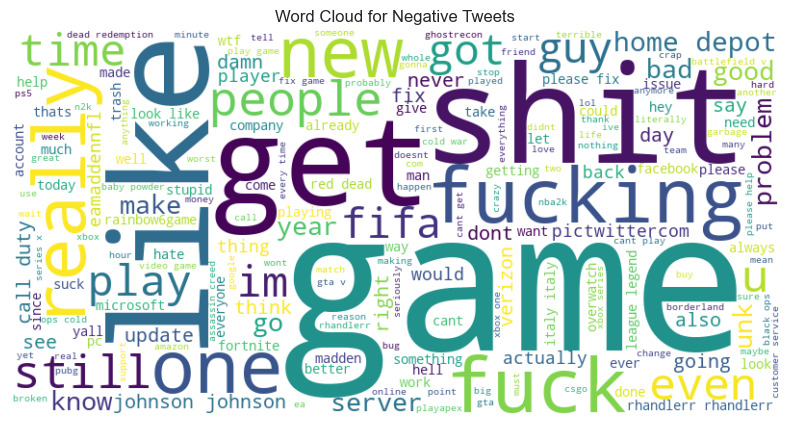

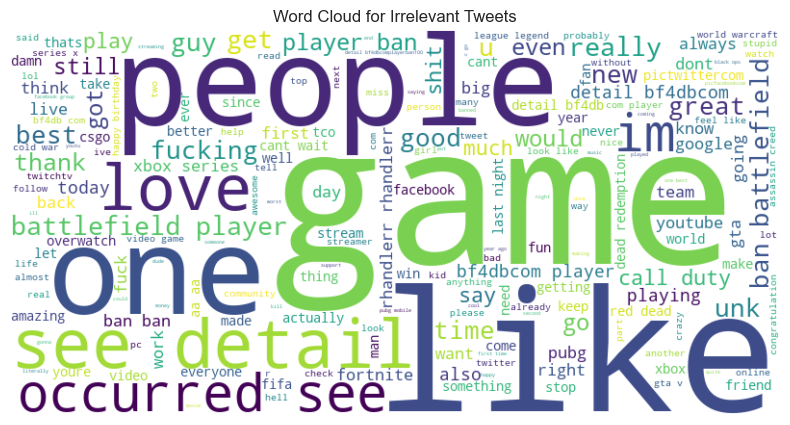

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word clouds by sentiment (focus on toxic/negative)
for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]['clean_tweet']
    if len(subset) > 0:
        generate_wordcloud(subset, f"Word Cloud for {sentiment} Tweets")

#### 4. Advanced EDA - Tweet Lengths and Entity-Sentiment Crosstab

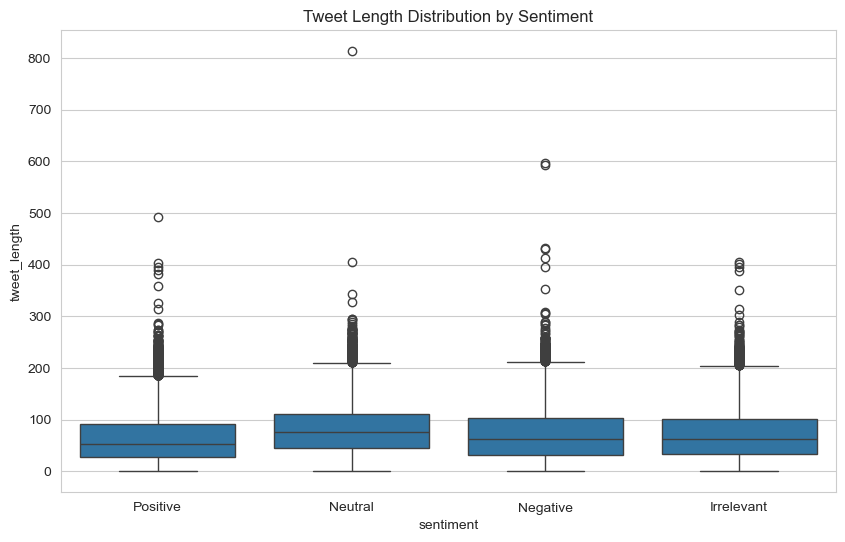

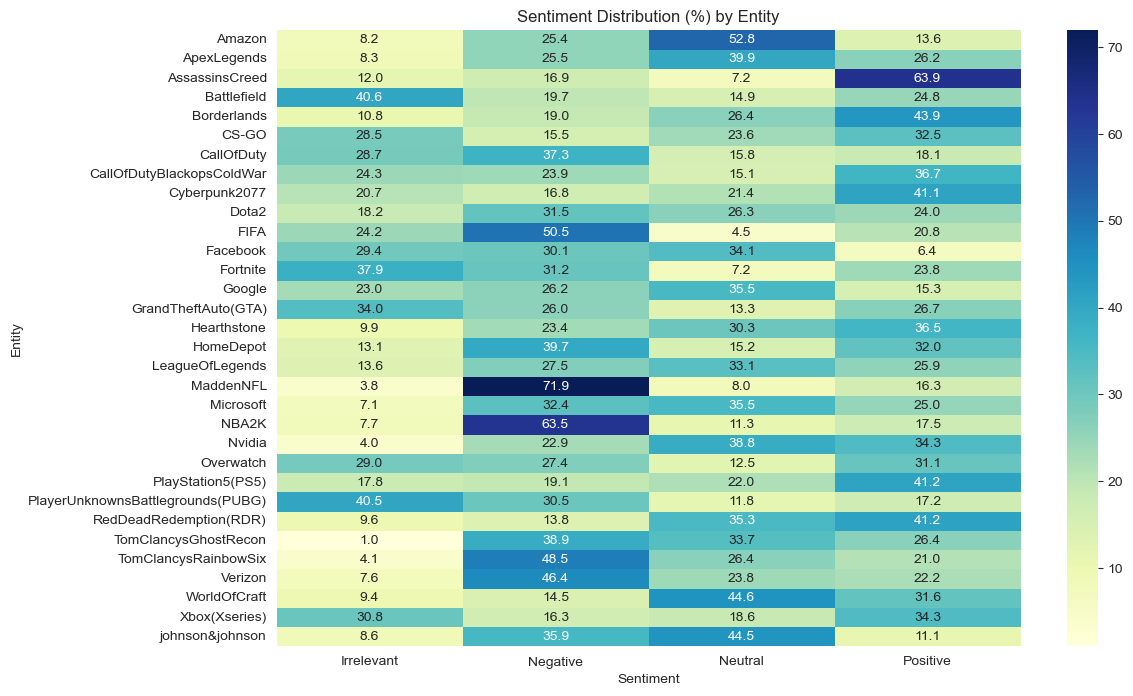

Top 5 Most Toxic Entities (% Negative):
sentiment              Negative
entity                         
MaddenNFL             71.946903
NBA2K                 63.514719
FIFA                  50.505051
TomClancysRainbowSix  48.528746
Verizon               46.412755


In [53]:
import seaborn as sns

# Tweet length analysis
df['tweet_length'] = df['clean_tweet'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='tweet_length')
plt.title('Tweet Length Distribution by Sentiment')
plt.show()

# Entity-Sentiment crosstab (toxicity per entity)
crosstab = pd.crosstab(df['entity'], df['sentiment'], normalize='index') * 100  # Percentage
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Sentiment Distribution (%) by Entity')
plt.ylabel('Entity')
plt.xlabel('Sentiment')
plt.show()

# Print top toxic entities (highest % Negative)
toxic_entities = crosstab.sort_values('Negative', ascending=False).head(5)
print("Top 5 Most Toxic Entities (% Negative):")
print(toxic_entities[['Negative']])

#### 5. Encode Labels

In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

print("Encoded Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Encoded Mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


#### 6. Feature Engineering - TF-IDF Vectorization

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF with bigrams for better context (e.g., toxic phrases)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X = vectorizer.fit_transform(df['clean_tweet'])
y = df['sentiment_encoded']

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (69491, 5000)


#### 7. Data Splitting

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 55592, Test size: 13899


#### 8. Model Training and Evaluation (Baseline Models)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:
              precision    recall  f1-score   support

  Irrelevant       0.56      0.65      0.60      2443
    Negative       0.76      0.73      0.75      4234
     Neutral       0.63      0.63      0.63      3409
    Positive       0.71      0.68      0.69      3813

    accuracy                           0.68     13899
   macro avg       0.67      0.67      0.67     13899
weighted avg       0.68      0.68      0.68     13899



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


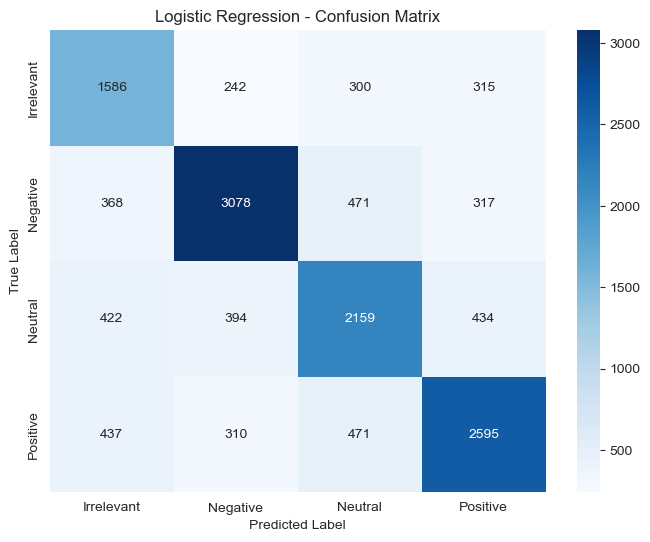


Naive Bayes Results:
              precision    recall  f1-score   support

  Irrelevant       0.69      0.36      0.47      2443
    Negative       0.63      0.80      0.70      4234
     Neutral       0.66      0.53      0.59      3409
    Positive       0.62      0.73      0.67      3813

    accuracy                           0.64     13899
   macro avg       0.65      0.60      0.61     13899
weighted avg       0.64      0.64      0.62     13899



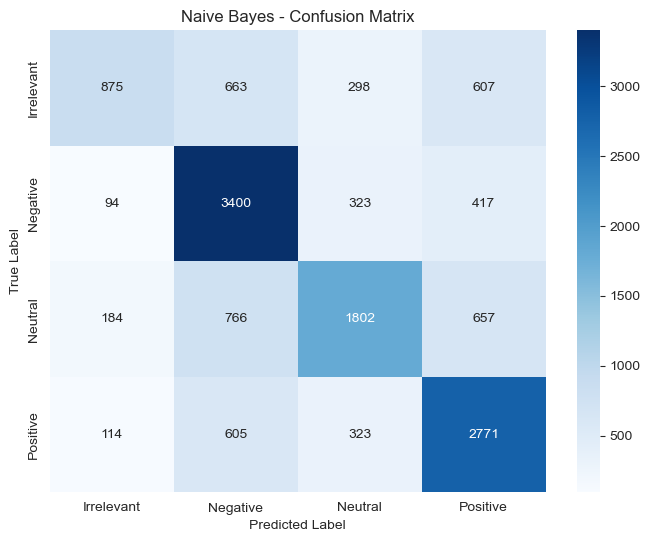


Model Comparison:
                     Accuracy
Logistic Regression  0.677603
Naive Bayes          0.636593


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Models with class weights to handle imbalance
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=42),
    'Naive Bayes': MultinomialNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {'Accuracy': acc, 'Predictions': y_pred}
    
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Model comparison table
comparison_df = pd.DataFrame({name: {'Accuracy': data['Accuracy']} for name, data in results.items()})
print("\nModel Comparison:")
print(comparison_df.T)

#### 9. Hyperparameter Tuning with Cross-Validation

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Example tuning for Logistic Regression
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid = GridSearchCV(LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=42), 
                    param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

# Use tuned model for final prediction
y_pred_tuned = grid.predict(X_test)
print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

Best params: {'C': 10, 'solver': 'lbfgs'}
Best CV F1: 0.6737005737095092

Tuned Model Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.59      0.67      0.62      2443
    Negative       0.78      0.73      0.76      4234
     Neutral       0.64      0.66      0.65      3409
    Positive       0.72      0.68      0.70      3813

    accuracy                           0.69     13899
   macro avg       0.68      0.69      0.68     13899
weighted avg       0.70      0.69      0.69     13899



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 10. Save Model and Vectorizer

In [69]:
import joblib

# Save for future use
joblib.dump(le, 'sentiment_encoder.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(grid.best_estimator_, 'sentiment_model.pkl')  # Or use your best model

print("Model, vectorizer, and encoder saved!")

Model, vectorizer, and encoder saved!


#### 11. Prediction Function (For New Tweets)

In [71]:
def predict_sentiment(new_tweet):
    cleaned = clean_text(new_tweet)
    vec = vectorizer.transform([cleaned])
    pred = grid.best_estimator_.predict(vec)[0]
    prob = grid.best_estimator_.predict_proba(vec)[0]
    return le.inverse_transform([pred])[0], dict(zip(le.classes_, prob))

# Example usage
example_tweet = "This game is full of toxic players, I hate it!"
sentiment, probs = predict_sentiment(example_tweet)
print(f"Predicted Sentiment: {sentiment}")
print(f"Probabilities: {probs}")

Predicted Sentiment: Negative
Probabilities: {'Irrelevant': 0.28142826293533224, 'Negative': 0.6925586052991074, 'Neutral': 0.025819127228476017, 'Positive': 0.0001940045370844083}


### Checking if the model training is successful or not?

#### 1. Check Model Parameters

In [162]:
import joblib
loaded_model = joblib.load('sentiment_model.pkl')
print("Coefficients (first 5 for class 0):", loaded_model.coef_[0][:5])
print("Intercepts:", loaded_model.intercept_)

Coefficients (first 5 for class 0): [ 1.11984142  2.55267824 -0.21431511  2.64629442  2.21131835]
Intercepts: [-0.03782429 -0.04597613  0.13905236 -0.05525195]


#### 2. Test Predictions on Sample Tweets

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import pandas as pd

# Load vectorizer and label encoder
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le = joblib.load('sentiment_encoder.pkl')
loaded_model = joblib.load('sentiment_model.pkl')

# Test on a dataset tweet
sample_tweet = df['clean_tweet'].iloc[0]
sample_vec = vectorizer.transform([sample_tweet])
pred = loaded_model.predict(sample_vec)[0]
print(f"Dataset Tweet: {df['tweet'].iloc[0]}")
print(f"Predicted Sentiment: {le.inverse_transform([pred])[0]}")

# Test on a known toxic tweet
toxic_tweet = "This game is trash, full of toxic idiots!"
toxic_vec = vectorizer.transform([clean_text(toxic_tweet)])  # Ensure clean_text from Cell 2 is defined
pred_toxic = loaded_model.predict(toxic_vec)[0]
print(f"Toxic Tweet: {toxic_tweet}")
print(f"Predicted Sentiment: {le.inverse_transform([pred_toxic])[0]}")

Dataset Tweet: I am coming to the borders and I will kill you all,
Predicted Sentiment: Positive
Toxic Tweet: This game is trash, full of toxic idiots!
Predicted Sentiment: Negative


#### 3. Re-evaluate Model Performance

Tuned Model Accuracy: 0.690481329592057
Tuned Model Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.59      0.67      0.62      2443
    Negative       0.78      0.73      0.76      4234
     Neutral       0.64      0.66      0.65      3409
    Positive       0.72      0.68      0.70      3813

    accuracy                           0.69     13899
   macro avg       0.68      0.69      0.68     13899
weighted avg       0.70      0.69      0.69     13899



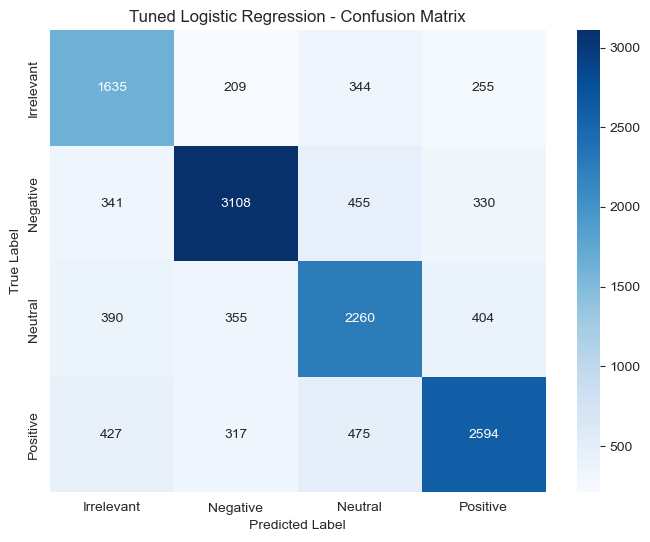

In [168]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load necessary objects
loaded_model = joblib.load('sentiment_model.pkl')
le = joblib.load('sentiment_encoder.pkl')

# Predict on test set
y_pred = loaded_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred))
print("Tuned Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Tuned Logistic Regression - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### 4. Check for Overfitting

In [171]:
# Training set performance
y_train_pred = loaded_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 0.763131385810908
Test Accuracy: 0.690481329592057


### Test More Toxic Tweets:

In [179]:
toxic_tweets = [
    "This game is full of cheaters and toxic players!",
    "I hate this stupid app, it’s garbage!",
    "Worst community ever, toxic trash talkers!"
]
for tweet in toxic_tweets:
    vec = vectorizer.transform([clean_text(tweet)])
    pred = loaded_model.predict(vec)[0]
    print(f"Tweet: {tweet}")
    print(f"Predicted: {le.inverse_transform([pred])[0]}\n")

Tweet: This game is full of cheaters and toxic players!
Predicted: Negative

Tweet: I hate this stupid app, it’s garbage!
Predicted: Negative

Tweet: Worst community ever, toxic trash talkers!
Predicted: Negative

